In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Modifica questo con il percorso alla tua cartella
data_dir = "/content/drive/MyDrive/SL_Project/binary_one_type_split"

# Dimensione standard, modificabile
image_size = 256

# Trasformazioni da applicare: resize, tensorizzazione e normalizzazione
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # per 3 canali
])

# Dataset per train e validation
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# DataLoader per batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*32*32, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # (3, 256, 256)
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128):
        super().__init__()
        # Congela l'encoder, tranne ultimo layer
        for param in encoder.parameters():
            param.requires_grad = False

        for i in range(6, len(encoder)): # Unfreeze from index 6 till the end of encoder
            for param in encoder[i].parameters():
                param.requires_grad = True

        self.encoder = encoder  # encoder già addestrato

        # Head di classificazione
        self.classifier = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(0.3),

                    nn.Linear(128, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.Dropout(0.3),

                    nn.Linear(64, 1)
                )

    def forward(self, x):
        z = self.encoder(x)  # ottieni le feature compresse
        return self.classifier(z)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(latent_dim=128)
model.load_state_dict(torch.load("/content/autoencoder.pth"))
model.eval()

encoder = model.encoder

# Crea il classificatore completo
classifier_model = TumorClassifier(encoder, latent_dim=128).to(device)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Usa BCEWithLogitsLoss, quindi togliamo la sigmoid nella classifier (opzionale ma consigliato)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=1e-4)
num_epochs = 20

for epoch in range(num_epochs):
    classifier_model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape (B, 1)

        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # ----------------------
    # 🧪 Valutazione su test set
    classifier_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = classifier_model(images)
            preds = torch.sigmoid(outputs) > 0.75  # binarizza le predizioni
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcolo metriche
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

Using device: cuda
Epoch [1/20]
Train Loss: 0.6043 | Acc: 0.6106 | Prec: 0.9077 | Rec: 0.2950 | F1: 0.4453
Epoch [2/20]
Train Loss: 0.4605 | Acc: 0.6874 | Prec: 0.9607 | Rec: 0.4275 | F1: 0.5917
Epoch [3/20]
Train Loss: 0.3762 | Acc: 0.7974 | Prec: 0.9768 | Rec: 0.6325 | F1: 0.7678
Epoch [4/20]
Train Loss: 0.3110 | Acc: 0.8556 | Prec: 0.9619 | Rec: 0.7575 | F1: 0.8476
Epoch [5/20]
Train Loss: 0.2635 | Acc: 0.8861 | Prec: 0.9673 | Rec: 0.8125 | F1: 0.8832
Epoch [6/20]
Train Loss: 0.2306 | Acc: 0.8980 | Prec: 0.9681 | Rec: 0.8350 | F1: 0.8966
Epoch [7/20]
Train Loss: 0.2038 | Acc: 0.9192 | Prec: 0.9695 | Rec: 0.8750 | F1: 0.9198
Epoch [8/20]
Train Loss: 0.1805 | Acc: 0.9258 | Prec: 0.9725 | Rec: 0.8850 | F1: 0.9267
Epoch [9/20]
Train Loss: 0.1616 | Acc: 0.9417 | Prec: 0.9785 | Rec: 0.9100 | F1: 0.9430
Epoch [10/20]
Train Loss: 0.1431 | Acc: 0.9563 | Prec: 0.9766 | Rec: 0.9400 | F1: 0.9580
Epoch [11/20]
Train Loss: 0.1265 | Acc: 0.9589 | Prec: 0.9792 | Rec: 0.9425 | F1: 0.9605
Epoch [12/2

In [14]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class=None):
        self.model.eval()

        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            # If target_class is not specified, take the class with the highest probability
            target_class = torch.sigmoid(output).argmax().item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass
        one_hot_output = torch.zeros_like(output)
        one_hot_output[:, target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Get gradients and activations
        guided_gradients = self.gradients
        activations = self.activations

        # Compute weights (global average pooling of gradients)
        weights = torch.mean(guided_gradients, dim=[2, 3], keepdim=True)

        # Compute CAM
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam) # Apply ReLU to remove negative values

        # Normalize CAM to 0-1
        cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.squeeze().detach().cpu().numpy()


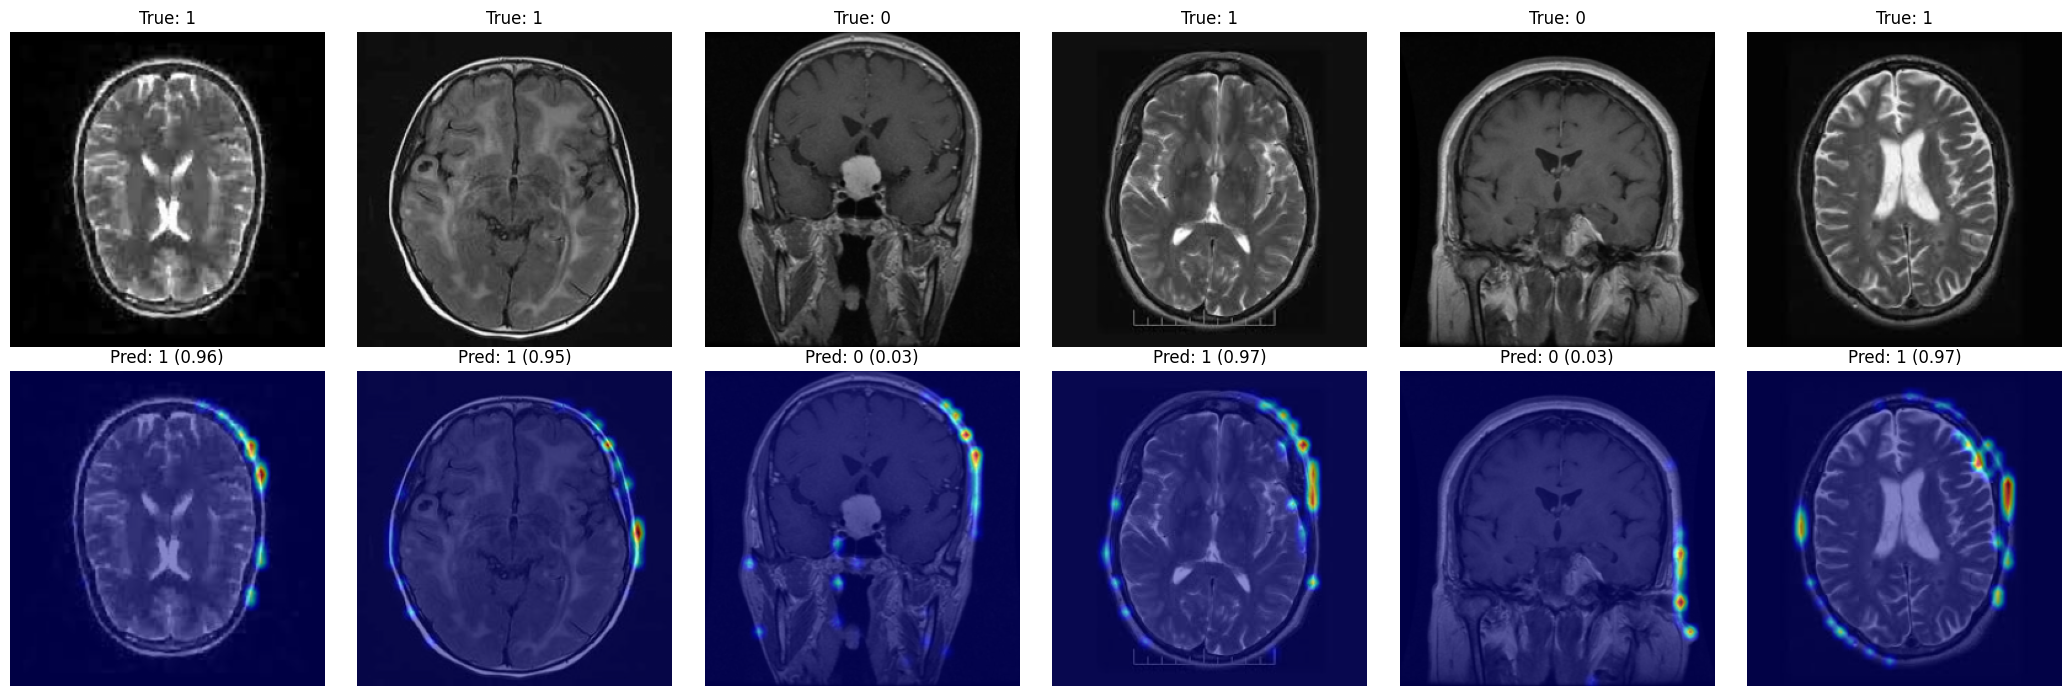

In [19]:
# --- Usage Example for Grad-CAM ---
import random
# Load a sample image from the test set
model.eval() # Ensure the autoencoder's encoder is in eval mode
classifier_model.eval() # Ensure the classifier is in eval mode

with torch.no_grad():
    images, labels = next(iter(test_loader))
    sample_image = images[0].unsqueeze(0).to(device) # Take the first image
    true_label = labels[0].item()

# Instantiate GradCAM
# We need to target the last convolutional layer of the encoder within the classifier model
# In your Autoencoder, the encoder's last Conv2d layer is at index 6:
# nn.Sequential(
#     nn.Conv2d(3, 32, ...), # 0
#     nn.BatchNorm2d(32),   # 1
#     nn.ReLU(),            # 2
#     nn.Conv2d(32, 64, ...), # 3
#     nn.BatchNorm2d(64),   # 4
#     nn.ReLU(),            # 5
#     nn.Conv2d(64, 128, ...), # 6 <--- Target layer for Grad-CAM
#     nn.BatchNorm2d(128),  # 7
#     nn.ReLU(),            # 8
#     nn.Flatten(),         # 9
#     nn.Linear(128*32*32, latent_dim) # 10
# )
grad_cam = GradCAM(classifier_model, classifier_model.encoder[6])

num_images_to_show = 6 # Number of random images to visualize

# --- MODIFICATION START ---
# Get random indices from the test_dataset
total_test_samples = len(test_dataset)
random_indices = random.sample(range(total_test_samples), num_images_to_show)

# Adjust figure size dynamically
# We'll plot two rows: Original Image and Superimposed CAM for predicted class
plt.figure(figsize=(num_images_to_show * 3.5, 7)) # Adjusted size for better display
# --- MODIFICATION END ---

for i, idx in enumerate(random_indices):
    # Retrieve the image and label using the random index from the dataset
    # We need to manually apply the transform if the dataset doesn't do it on __getitem__
    # (ImageFolder with transform in its constructor already handles it)
    sample_data, true_label = test_dataset[idx]

    # Add batch dimension and move to device
    sample_image = sample_data.unsqueeze(0).to(device)
    true_label = true_label # Label is already an int

    # Ensure the input image for Grad-CAM has requires_grad=True
    sample_image_for_cam = sample_image.clone().detach().requires_grad_(True)

    # Get CAM (e.g., for predicted class)
    # The GradCAM.__call__ method will automatically determine the target class if target_class=None
    cam_output = grad_cam(sample_image_for_cam)

    # De-normalize and display the original image
    original_image_display = (sample_image.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5

    # Overlay CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_output), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1] # Convert BGR to RGB

    original_image_display_float = np.float32(original_image_display)

    # Superimpose the heatmap on the original image
    superimposed_img = original_image_display_float + heatmap
    superimposed_img = superimposed_img / np.max(superimposed_img) # Normalize to prevent clipping

    # Get predicted class and probability for display
    # Use the original sample_image (no requires_grad) for simple prediction
    with torch.no_grad():
        predicted_logit = classifier_model(sample_image).item()
        predicted_prob = torch.sigmoid(torch.tensor(predicted_logit)).item()
        predicted_class = 1 if predicted_prob > 0.5 else 0 # Assuming 0.5 threshold for prediction


    # Plotting - Adjusted subplot indexing for random order
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(original_image_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {predicted_class} ({predicted_prob:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()